<a href="https://www.kaggle.com/code/misaelcribeiro/tps-rfe-logging-of-many-models-performance?scriptVersionId=102803984" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


<h3 style="text-align: center;">Loading libraries</h3>

In [2]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import auc,roc_curve, RocCurveDisplay
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

<h4 style="text-align: center;">We are going to see which model without any hyperparameter tunning will perform best. So, let's create a dict to keep the scores updated.</h4>

In [3]:
models_performance = {}

def fit_and_draw_roc_auc(model):
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, predictions[:, 1])
    roc_auc = auc(fpr, tpr)
    print(f'roc_auc: {roc_auc}')
    models_performance[str(model).split('(')[0]] = roc_auc
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=str(model).split('(')[0])
    display.plot()
    plt.show()
    plt.clf()

<h4 style="text-align: center;">Loading the data</h4>

In [4]:
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/train.csv').set_index('id')
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/test.csv').set_index('id')

In [5]:
print(train_df.shape)
print(test_df.shape)

(26570, 25)
(20775, 24)


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20775 entries, 26570 to 47344
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_code    20775 non-null  object 
 1   loading         20552 non-null  float64
 2   attribute_0     20775 non-null  object 
 3   attribute_1     20775 non-null  object 
 4   attribute_2     20775 non-null  int64  
 5   attribute_3     20775 non-null  int64  
 6   measurement_0   20775 non-null  int64  
 7   measurement_1   20775 non-null  int64  
 8   measurement_2   20775 non-null  int64  
 9   measurement_3   20446 non-null  float64
 10  measurement_4   20366 non-null  float64
 11  measurement_5   20267 non-null  float64
 12  measurement_6   20151 non-null  float64
 13  measurement_7   20055 non-null  float64
 14  measurement_8   19929 non-null  float64
 15  measurement_9   19871 non-null  float64
 16  measurement_10  19708 non-null  float64
 17  measurement_11  19639 non-n

<h3 style="text-align: center;">Treating features...</h3>

In [7]:
attributes = [x for x in train_df.columns if x.startswith('attribute')]
measurements = [x for x in train_df.columns if x.startswith('measurement')]
attributes, measurements

(['attribute_0', 'attribute_1', 'attribute_2', 'attribute_3'],
 ['measurement_0',
  'measurement_1',
  'measurement_2',
  'measurement_3',
  'measurement_4',
  'measurement_5',
  'measurement_6',
  'measurement_7',
  'measurement_8',
  'measurement_9',
  'measurement_10',
  'measurement_11',
  'measurement_12',
  'measurement_13',
  'measurement_14',
  'measurement_15',
  'measurement_16',
  'measurement_17'])

In [8]:
null_cols = train_df.isnull().sum().sort_values(ascending=False)
null_cols = list(null_cols[null_cols>1].index)
null_cols

['measurement_17',
 'measurement_16',
 'measurement_15',
 'measurement_14',
 'measurement_13',
 'measurement_12',
 'measurement_11',
 'measurement_10',
 'measurement_9',
 'measurement_8',
 'measurement_7',
 'measurement_6',
 'measurement_5',
 'measurement_4',
 'measurement_3',
 'loading']

In [9]:
object_cols = list(train_df.select_dtypes(include=['object']))
numerics_cols = list(train_df.select_dtypes(exclude=['object']))
numerics_cols.remove('failure')
numerics_cols

['loading',
 'attribute_2',
 'attribute_3',
 'measurement_0',
 'measurement_1',
 'measurement_2',
 'measurement_3',
 'measurement_4',
 'measurement_5',
 'measurement_6',
 'measurement_7',
 'measurement_8',
 'measurement_9',
 'measurement_10',
 'measurement_11',
 'measurement_12',
 'measurement_13',
 'measurement_14',
 'measurement_15',
 'measurement_16',
 'measurement_17']

In [10]:
measurement_cols = [i for i in train_df.columns if i.startswith('measu')]
attribute_cols = [i for i in train_df.columns if i.startswith('attri')]
attribute_cols

['attribute_0', 'attribute_1', 'attribute_2', 'attribute_3']

In [11]:
train_df['measurement_t1'] = train_df[measurement_cols].sum(axis=1)
train_df['attribute_t1'] = train_df[attribute_cols].sum(axis=1)

test_df['measurement_t1'] = test_df[measurement_cols].sum(axis=1)
test_df['attribute_t1'] = test_df[attribute_cols].sum(axis=1)

test_df['att2*3'] = test_df['attribute_2']*test_df['attribute_3']
train_df['att2*3'] = train_df['attribute_2']*train_df['attribute_3']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


In [12]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

sp = SimpleImputer(strategy='mean')

ct = ColumnTransformer([("imp", SimpleImputer(), null_cols)])
    
train_df[null_cols] = ct.fit_transform(train_df[null_cols])
test_df[null_cols] = ct.fit_transform(test_df[null_cols])

In [13]:
pd.set_option('display.max_columns', 30)
train_df

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,measurement_t1,attribute_t1,att2*3
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,12.518000,15.748,19.292,11.739,20.155,10.672000,15.859,17.594000,15.193,15.029,16.048444,13.034,14.684000,764.100,0,982.657,14,45
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,11.540000,17.717,17.893,12.748,17.889,12.448000,17.947,17.915000,11.755,14.732,15.425000,14.395,15.631000,682.057,0,918.305,14,45
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,11.652000,16.738,18.240,12.718,18.288,12.715000,15.607,19.172085,13.798,16.711,18.631000,14.094,17.946000,663.376,0,886.571,14,45
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,11.188000,18.576,18.339,12.583,19.060,12.471000,16.346,18.377000,10.020,15.250,15.562000,16.154,17.172000,826.282,0,1065.675,14,45
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,12.950000,16.990,15.746,11.306,18.093,10.337000,17.082,19.932000,12.428,16.182,12.760000,13.153,16.412000,579.885,0,811.602,14,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,E,158.95,material_7,material_6,6,9,6,16,4,16.301,13.259000,18.068,15.505,10.865,19.354,11.430725,12.177,17.942000,10.112,15.795,18.572000,16.144,16.460727,729.131,0,939.225,15,54
26566,E,146.02,material_7,material_6,6,9,10,12,8,17.543,11.731988,17.984,19.078,11.139,19.563,11.242000,14.179,20.564000,10.234,14.450,14.322000,13.146,16.471000,853.924,0,1083.839,15,54
26567,E,115.62,material_7,material_6,6,9,1,10,1,15.670,11.535000,16.778,18.385,11.630,19.279,11.407000,16.437,17.476000,8.668,15.069,16.599000,15.590,14.065000,750.364,0,970.952,15,54


In [14]:
#One Hot Encoding

full_df_for_dummies = pd.concat([train_df, test_df])
full_df_for_dummies = pd.get_dummies(full_df_for_dummies)
train_df = full_df_for_dummies.iloc[0:26570,:]
test_df = full_df_for_dummies.iloc[26570:,:]
test_df.drop('failure', inplace=True, axis=1)

del full_df_for_dummies

#train_df.fillna(0, inplace=True)
#test_df.fillna(0, inplace=True)

X = train_df.copy()
y = X.pop('failure')
#test_df.drop('failure', axis=1, inplace=True)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)

#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import StandardScaler

#ct = ColumnTransformer(
#    [("standS", StandardScaler(), numerics_cols)])
     
#X_train[numerics_cols] = ct.fit_transform(X_train[numerics_cols])
#X_test[numerics_cols] = ct.fit_transform(X_test[numerics_cols])
#test_df[numerics_cols] = ct.fit_transform(test_df[numerics_cols])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


roc_auc: 0.5906779931234929


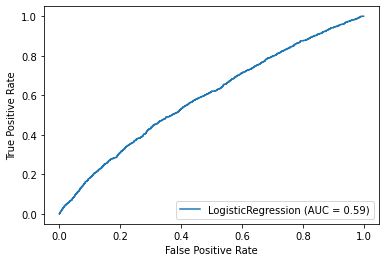

<Figure size 432x288 with 0 Axes>

In [15]:
fit_and_draw_roc_auc(LogisticRegression(penalty="l2", solver='liblinear'))

roc_auc: 0.5572154820850884


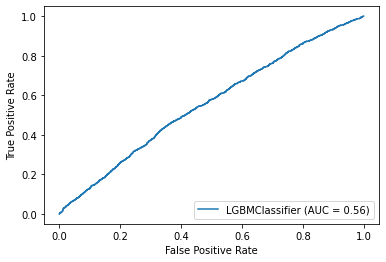

<Figure size 432x288 with 0 Axes>

In [16]:
fit_and_draw_roc_auc(LGBMClassifier())

roc_auc: 0.5464495249027485


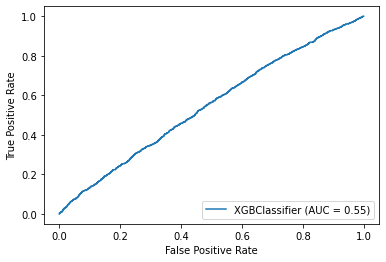

<Figure size 432x288 with 0 Axes>

In [17]:
fit_and_draw_roc_auc(XGBClassifier())

roc_auc: 0.5478052760600921


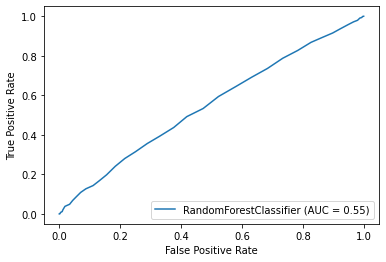

<Figure size 432x288 with 0 Axes>

In [18]:
fit_and_draw_roc_auc(RandomForestClassifier())

roc_auc: 0.5769601071792594


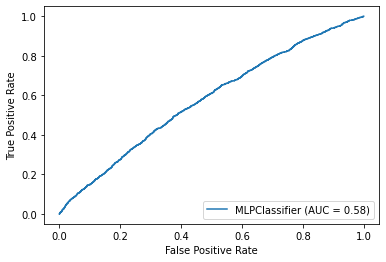

<Figure size 432x288 with 0 Axes>

In [19]:
fit_and_draw_roc_auc(MLPClassifier(max_iter=400))

roc_auc: 0.5113836754833389


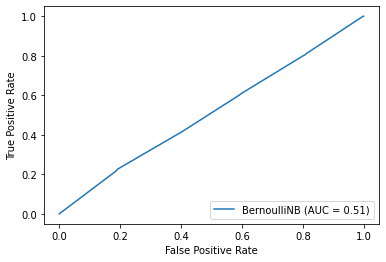

<Figure size 432x288 with 0 Axes>

In [20]:
fit_and_draw_roc_auc(BernoulliNB())

roc_auc: 0.5586268981461965


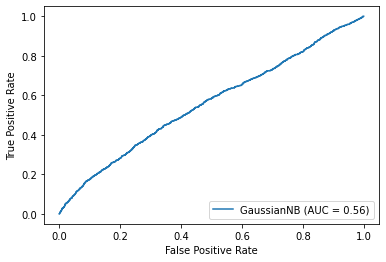

<Figure size 432x288 with 0 Axes>

In [21]:
fit_and_draw_roc_auc(GaussianNB())

<h3 style="text-align: center;">Let's see the two models that performed better and perform a Grid Search on it!</h3>

In [22]:
models_performance

{'LogisticRegression': 0.5906779931234929,
 'LGBMClassifier': 0.5572154820850884,
 'XGBClassifier': 0.5464495249027485,
 'RandomForestClassifier': 0.5478052760600921,
 'MLPClassifier': 0.5769601071792594,
 'BernoulliNB': 0.5113836754833389,
 'GaussianNB': 0.5586268981461965}

<h3 style="text-align: center;">Logistic Regression rocks! Grid Search time:</h3>

In [23]:
param_grid = {'penalty':('l1', 'l2'), 'C':[0.5, 1, 2, 5, 10]}
LR = LogisticRegression(solver='liblinear')
clf = GridSearchCV(LR, param_grid, scoring='roc_auc', n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', return_train_score=False)
clf.fit(X, y)
print(clf.best_params_)

{'C': 0.5, 'penalty': 'l1'}


In [24]:
from sklearn.feature_selection import RFE

estimator = LogisticRegression(penalty="l1", solver='liblinear', C=1)
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)
best_cols = selector.get_feature_names_out()


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [25]:
best_cols

array(['attribute_2', 'attribute_3', 'measurement_5', 'product_code_C',
       'product_code_D'], dtype=object)

In [33]:
X['sum_best_cols'] = X[best_cols].sum(axis=1)
test_df['sum_best_cols'] = test_df[best_cols].sum(axis=1)   

X['mean_best_cols'] = X[best_cols].mean(axis=1)
test_df['mean_best_cols'] = test_df[best_cols].mean(axis=1)  

X['std_best_cols'] = X[best_cols].std(axis=1)
test_df['std_best_cols'] = test_df[best_cols].std(axis=1) 

In [39]:
final_lr = LogisticRegression(penalty="l1", solver='liblinear', C=1)
final_lr.fit(X, y)
final_predictions = final_lr.predict_proba(test_df)

In [40]:
submission = pd.DataFrame(index=test_df.index)
submission['failure'] =  final_predictions[:, 1]
submission.to_csv('submission.csv')

<h1 style="text-align: center;">Work on progress!</h1>